# Helper Functions

In [1]:
import numpy as np

# For math and stats operations
from scipy.spatial.transform import Rotation as R
from scipy.stats import multivariate_normal

# For plotting
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly

# For saving and loading
import pickle

In [2]:
def protein_plot2d(state):
    for triangle in state:
        triangle_x = triangle[:,0]
        triangle_x = np.append(triangle_x, triangle_x[0])
        triangle_y = triangle[:,1]
        triangle_y = np.append(triangle_y, triangle_y[0])

        plt.plot(triangle_x, triangle_y)
            
    plt.show()


def protein_plot3d(state, ntfree):
    x = state[0][:2, 0]
    y = state[0][:2, 1]
    z = state[0][:2, 2]

    for triangle in state:
        x = np.append(x, triangle[2, 0])
        y = np.append(y, triangle[2, 1])
        z = np.append(z, triangle[2, 2])

    trace1 = go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='markers',
        name='markers'
    )

    #the start and end point for each line
    pairs = [(0,1), (1,2), (2,0)]

    for side in ntfree[:-1 or None]:
        start_end = pairs[-2] if side == 0 else pairs[-1]
        new_pt = np.max(start_end) + 1
        pairs = pairs + [(start_end[1], new_pt), (new_pt, start_end[0])]

    x_lines = []
    y_lines = []
    z_lines = []

    #create the coordinate list for the lines
    for p in pairs:
        for i in range(2):
            x_lines.append(x[p[i]])
            y_lines.append(y[p[i]])
            z_lines.append(z[p[i]])
        x_lines.append(None)
        y_lines.append(None)
        z_lines.append(None)

    trace2 = go.Scatter3d(
        x=x_lines,
        y=y_lines,
        z=z_lines,
        mode='lines',
        name='lines'
    )

    fig = go.Figure(data=[trace1, trace2])
    plotly.offline.iplot(fig, filename='simple-3d-scatter')


def protein_createblobs(coord_list, Q=400, n_cells=51, scale=10.0):
    images_list = []

    # Grids of x and y points
    x = np.linspace(-Q, Q, n_cells)
    y = np.linspace(-Q, Q, n_cells)
    z = np.linspace(-Q, Q, n_cells)
    # Create a 2-D meshgrid of (x, y) coordinates.
    x, y, z = np.meshgrid(x, y, z)

    # Creating mixture of gaussians
    pos = np.empty(x.shape + (3,))
    pos[:, :, :, 0] = x
    pos[:, :, :, 1] = y
    pos[:, :, :, 2] = z

    for state in coord_list:
        var0 = multivariate_normal(mean=[state[0][0, 0], state[0][0, 1], state[0][0, 2]], cov=(scale/3)*np.eye(3))
        var1 = multivariate_normal(mean=[state[0][1, 0], state[0][1, 1], state[0][1, 2]], cov=(scale/3)*np.eye(3))
        normals = var0.pdf(pos) + var1.pdf(pos)

        for triangle in state:
            var = multivariate_normal(mean=[triangle[2, 0], triangle[2, 1], triangle[2, 2]], cov=(scale/3)*np.eye(3))
            normals = normals + var.pdf(pos)

        images_list.append(normals.sum(axis=2))

    return images_list

# Generate protein images

In [3]:
class protein_generate:
    def __init__(self, scale=10.0, centering=True):
        self.scale = float(scale)
        self.Q = None
        self.centering = centering
        self.ground_state = [np.array([[0.0, 0.0, 0.0], [self.scale, 0.0, 0.0],\
                            [np.random.uniform(high=self.scale), np.random.uniform(low=self.scale/2, high=2*self.scale), 0.0]])]
        self.notfree = np.random.choice(2, 1)
        self.atom_coords = []
        self.rotations = []
        self.cryoem_imgs = []


    def create_ground_state(self, num=1):
        for iter in range(num-1):
            # Create sides a, b, c for new triangle to add in ground state
            [a, b] = [self.ground_state[-1][1, 0:2], self.ground_state[-1][2, 0:2]] if self.notfree[-1] == 0\
                 else [self.ground_state[-1][2, 0:2], self.ground_state[-1][0, 0:2]]

            theta = np.random.uniform(low=np.pi/4, high=np.pi/2) 
            rot = np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])
            c = b + np.dot(rot, a - b) * np.random.uniform(low=self.scale/2, high=2*self.scale)/np.linalg.norm(a - b)
            d = self.ground_state[-1][self.notfree[-1], 0:2]

            old = np.hstack(([a,b,c], [[1.0], [1.0], [1.0]]))
            new = np.hstack(([a,b,d], [[1.0], [1.0], [1.0]]))

            # Make sure the new vertex and opposite vertex of adjacent triangle lie on different sides
            if np.linalg.det(old) * np.linalg.det(new) > 0:
                theta = -theta
                rot = np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])
                c = b + np.dot(rot, a - b) * np.random.uniform(low=self.scale/2, high=2*self.scale)/np.linalg.norm(a - b)

            self.ground_state.append(np.hstack(([a,b,c], [[0.0], [0.0], [0.0]])))
            self.notfree = np.append(self.notfree, np.random.choice(2, 1))

        # Introduce angles to change the ground state from 2d to 3d
        new_state = []

        for triangle, side in zip(self.ground_state, self.notfree):
            new_state.append(triangle*1.0)

            [a, b] = [new_state[-1][1], new_state[-1][2]] if side == 0 else [new_state[-1][2], new_state[-1][0]]
            r = R.from_rotvec(np.random.uniform(low=0, high=np.pi/3) * (a - b)/np.linalg.norm(a - b))

            for tri in new_state:
                for i in [0,1,2]:
                    tri[i] = b + r.apply(tri[i] - b)

        self.ground_state = new_state

        # Centering
        if self.centering:
            mean_centre = np.mean(self.ground_state, axis=(0, 1))
            self.ground_state = [triangle - mean_centre for triangle in self.ground_state]


    def create_atom_coords(self, num=1, conform=False):
        for n in range(num):
            new_state = []

            # Creating new state (conformation) by rotating ground state triangles
            for triangle, side in zip(self.ground_state, self.notfree):
                new_state.append(triangle*1.0)

                if conform:
                    [a, b] = [new_state[-1][1], new_state[-1][2]] if side == 0 else [new_state[-1][2], new_state[-1][0]]
                    r = R.from_rotvec(np.random.uniform(low=0, high=np.pi/20) * (a - b)/np.linalg.norm(a - b))

                    for tri in new_state:
                        for i in [0,1,2]:
                            tri[i] = b + r.apply(tri[i] - b)

            # Centering
            if self.centering:
                mean_centre = np.mean(new_state, axis=(0, 1))
                new_state = [triangle - mean_centre for triangle in new_state]

            # Rotation by random euler angles
            angles = np.pi * np.array([2,1,2]) * np.random.uniform(size=3)
            self.rotations.append(angles)
            r = R.from_euler('zyz', angles)

            for tri in new_state:
                for i in [0,1,2]:
                    tri[i] = r.apply(tri[i])

            # Appending this new state in list of Atomic coordinates as well as cryoem images
            self.atom_coords.append(new_state)

            if len(self.atom_coords) == 30:
                self.Q = np.max(self.atom_coords)*1.5
                self.cryoem_imgs = self.cryoem_imgs + protein_createblobs(self.atom_coords, Q=self.Q)
            elif len(self.atom_coords) > 30:
                self.cryoem_imgs = self.cryoem_imgs + protein_createblobs([new_state], Q=self.Q)


    def plot2d(self, index=-1):
        if index == -1:
            protein_plot2d(self.ground_state)
        elif index == -2:
            for state in self.atom_coords:
                protein_plot2d(state)
        else:
            protein_plot2d(self.atom_coords[index])


    def plot3d(self, index=-1):
        if index == -1:
            protein_plot3d(self.ground_state, self.notfree)
        elif index == -2:
            for state in self.atom_coords:
                protein_plot3d(state, self.notfree)
        else:
            protein_plot3d(self.atom_coords[index], self.notfree)


    def plotblobs(self, index=-1):
        if index == -1:
            for idx, img in enumerate(self.cryoem_imgs):
                c = plt.imshow(img, cmap ='gray', vmin = 0, vmax = np.abs(img).max(),\
                                extent = [-self.Q, self.Q, -self.Q, self.Q], interpolation = 'nearest', origin = 'lower')
                plt.colorbar(c)
                
                plt.title(f'Cryo-EM Image {idx}', fontweight = "bold")
                plt.show()
        else:
            c = plt.imshow(self.cryoem_imgs[index], cmap ='gray', vmin = 0, vmax = np.abs(self.cryoem_imgs[index]).max(),\
                            extent = [-self.Q, self.Q, -self.Q, self.Q], interpolation = 'nearest', origin = 'lower')
            plt.colorbar(c)
                
            plt.title(f'Cryo-EM Image {index}', fontweight = "bold")
            plt.show()
        
    
    def get_info(self, option="ground"):
        return self.Q, self.ground_state, self.notfree, self.atom_coords, self.rotations, self.cryoem_imgs

In [4]:
protein1 = protein_generate(scale = 5)
protein1.create_ground_state(num=100)

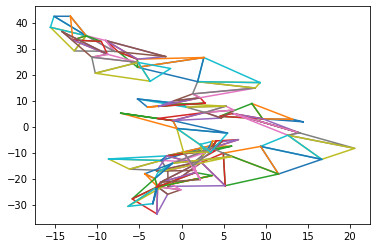

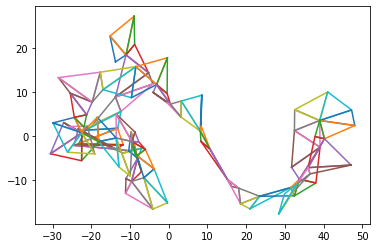

In [5]:
protein1.create_atom_coords(num=1000)
protein1.plot2d(index=-1)
protein1.plot2d(index=0)

protein1.plot3d(index=-1)
protein1.plot3d(index=0)

In [ ]:
protein1.plotblobs()

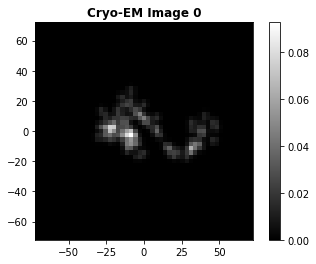

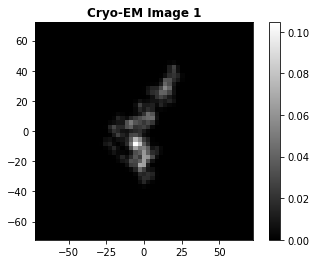

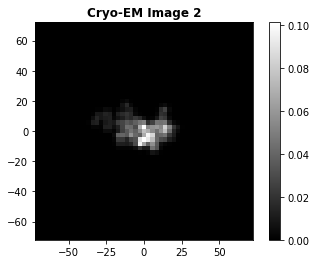

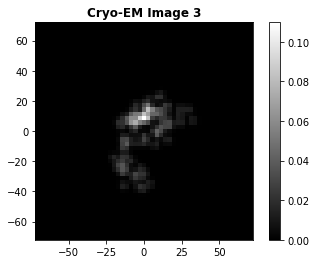

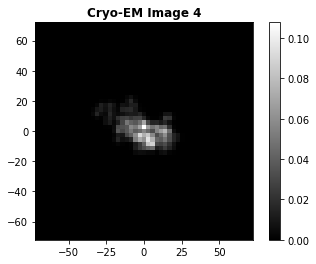

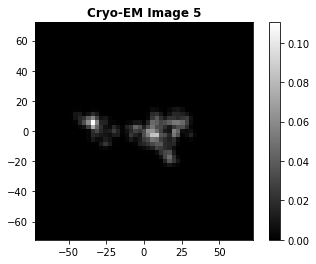

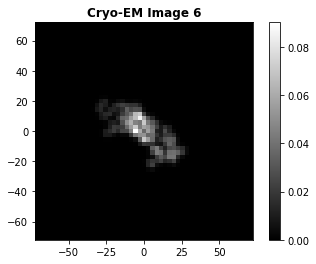

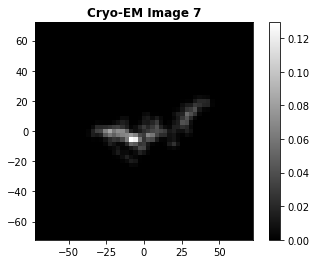

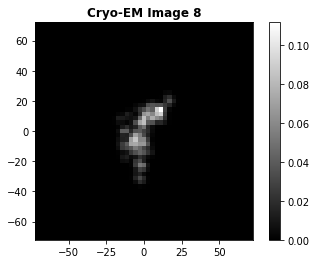

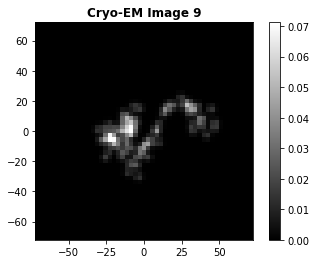

In [6]:
Q, ground_state, notfree, atom_coords, rotations, cryoem_imgs = protein1.get_info()

for idx, img in enumerate(cryoem_imgs[:10]):
    c = plt.imshow(img, cmap ='gray', vmin = 0, vmax = np.abs(img).max(),\
                    extent = [-Q, Q, -Q, Q], interpolation = 'nearest', origin = 'lower')
    plt.colorbar(c)
                
    plt.title(f'Cryo-EM Image {idx}', fontweight = "bold")
    plt.show()

In [7]:
with open('protein51x51_1000imgs.pkl', 'wb') as outp:
    pickle.dump(Q, outp, pickle.HIGHEST_PROTOCOL)
    pickle.dump(ground_state, outp, pickle.HIGHEST_PROTOCOL)
    pickle.dump(notfree, outp, pickle.HIGHEST_PROTOCOL)
    pickle.dump(atom_coords, outp, pickle.HIGHEST_PROTOCOL)
    pickle.dump(rotations, outp, pickle.HIGHEST_PROTOCOL)
    pickle.dump(cryoem_imgs, outp, pickle.HIGHEST_PROTOCOL)

with open('protein51x51_1000imgs.pkl', 'rb') as inp:
    q = pickle.load(inp)
    gst = pickle.load(inp)
    ntfr = pickle.load(inp)
    atmcrd = pickle.load(inp)
    rot = pickle.load(inp)
    imgs = pickle.load(inp)

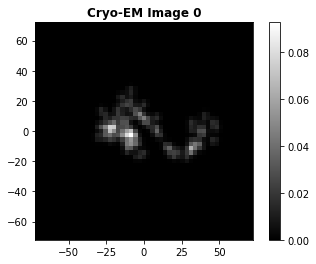

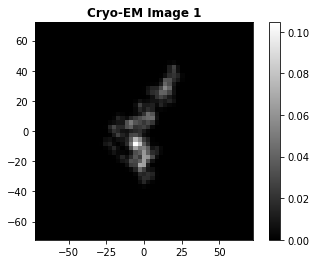

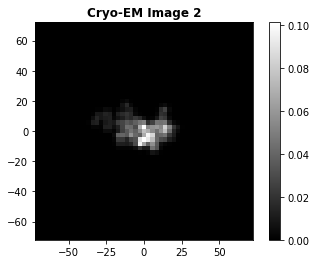

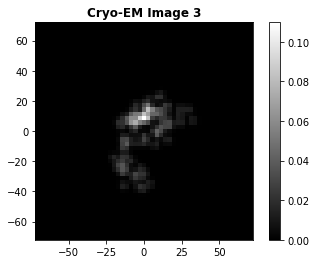

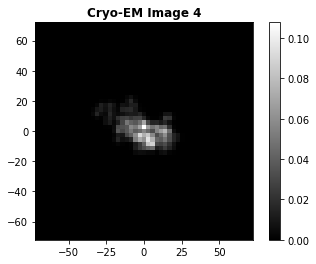

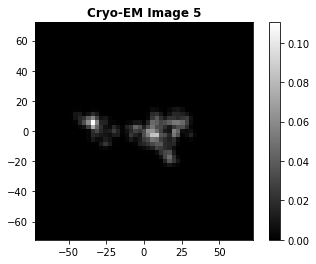

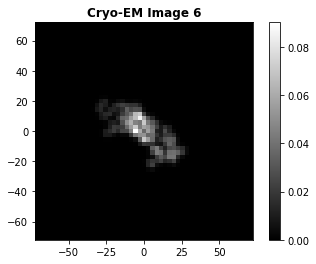

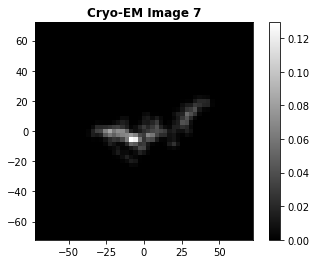

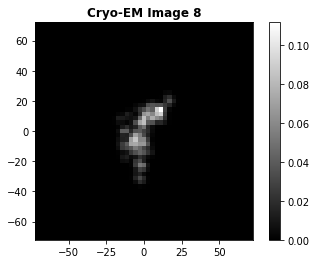

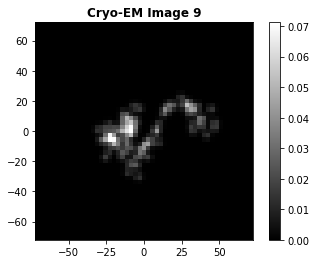

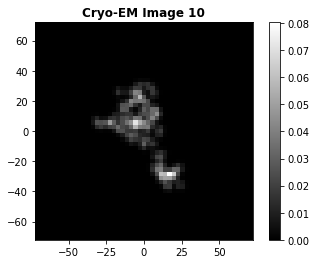

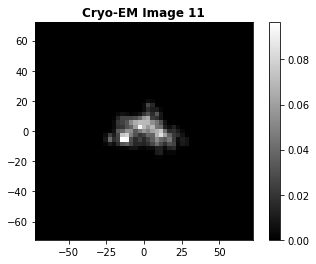

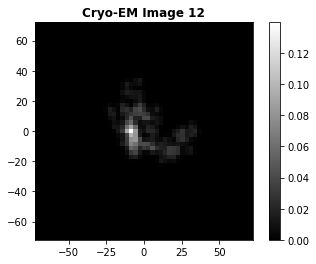

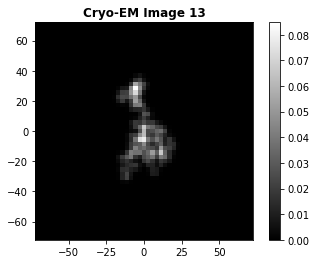

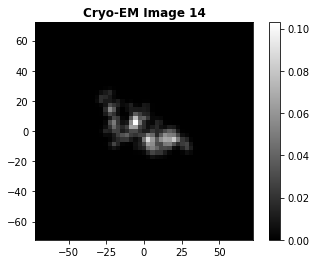

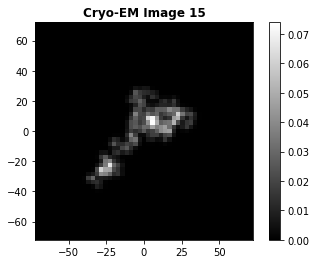

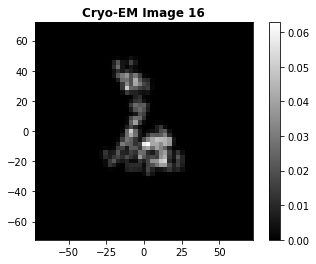

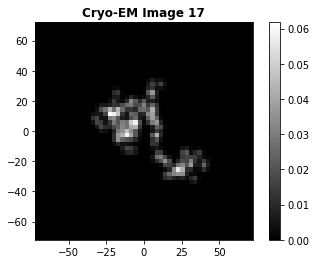

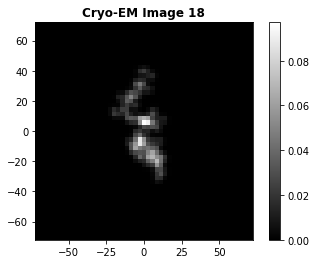

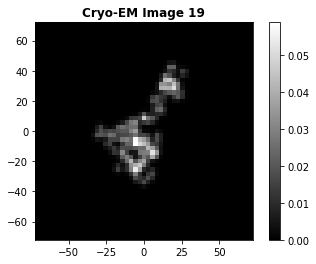

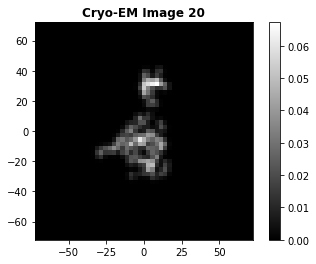

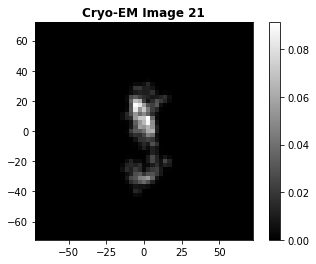

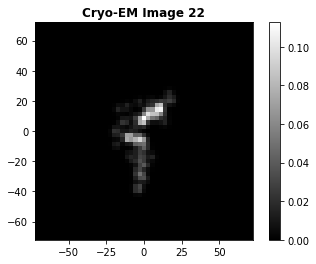

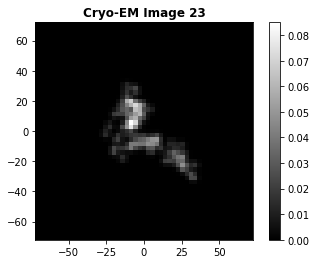

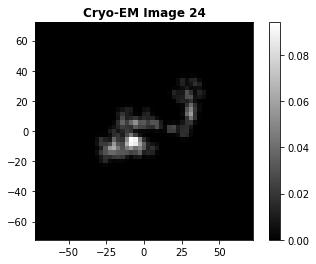

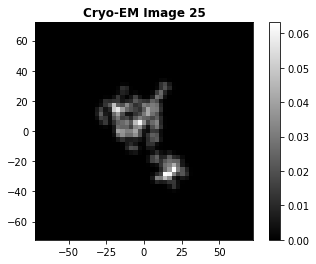

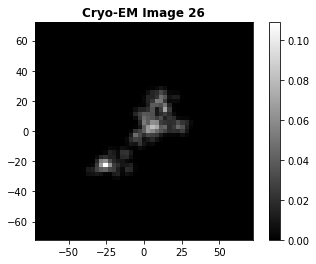

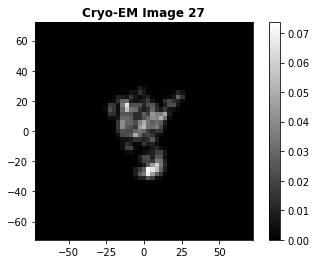

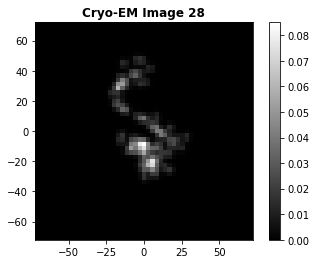

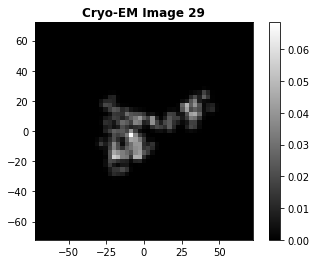

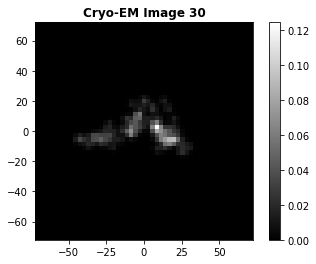

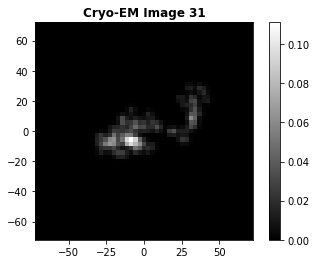

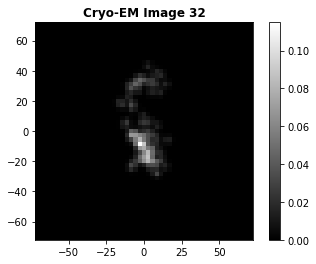

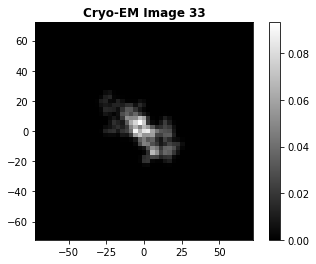

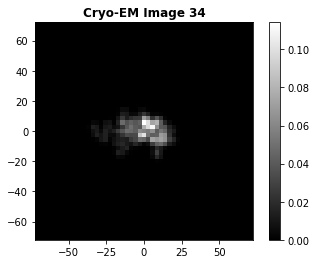

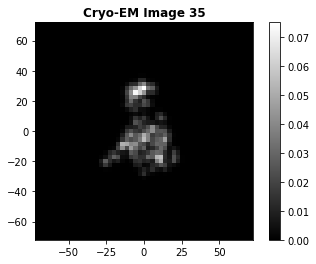

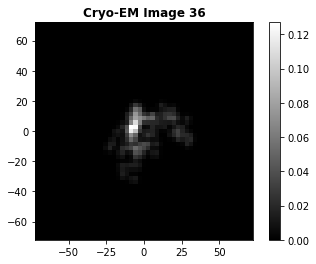

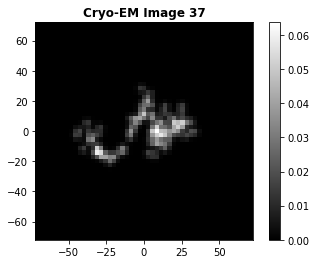

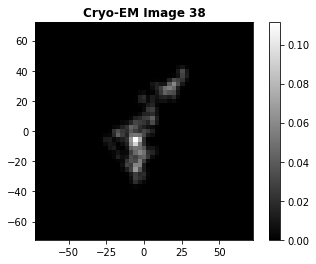

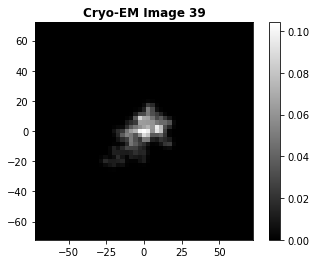

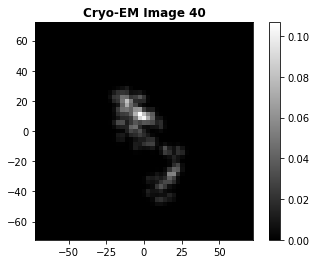

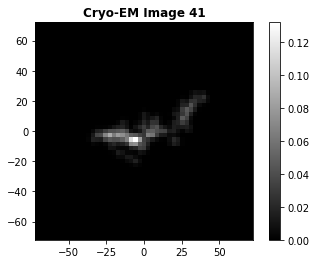

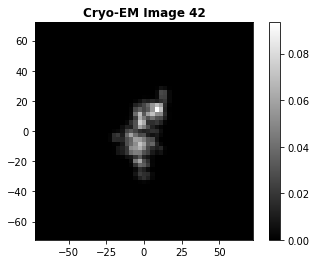

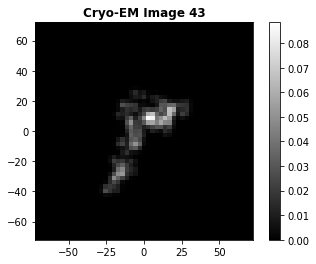

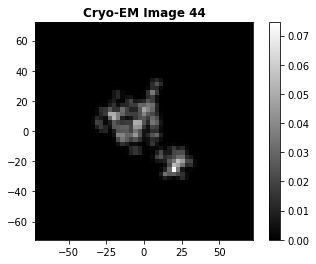

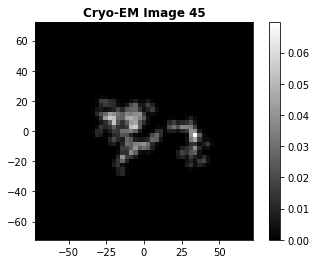

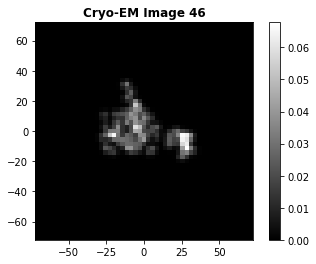

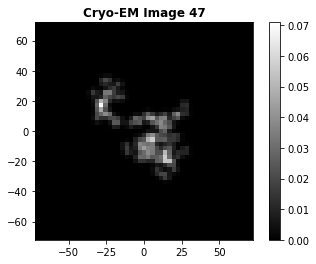

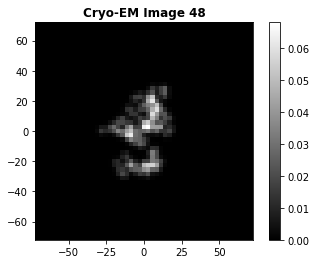

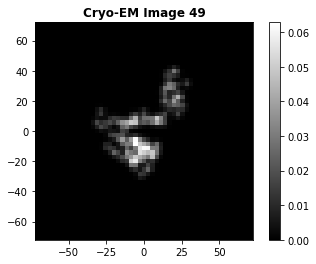

In [8]:
for idx, img in enumerate(imgs[:50]):
    c = plt.imshow(img, cmap ='gray', vmin = 0, vmax = np.abs(img).max(),\
                    extent = [-q, q, -q, q], interpolation = 'nearest', origin = 'lower')
    plt.colorbar(c)
                
    plt.title(f'Cryo-EM Image {idx}', fontweight = "bold")
    plt.show()